# Importing Libraries


In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
from sklearn.metrics import classification_report, confusion_matrix
 
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
 
import cv2
import os 
import warnings
warnings.filterwarnings('ignore')

In [93]:
# Importing Csvs
train_labels = pd.read_csv("../Data/train.csv")
test_labels = pd.read_csv("../Data/test.csv")
sample = pd.read_csv("../Data/sample_submission.csv")

path = "../Data/images/"

In [94]:
# Reversing one hot encoding
train_labels["condition"] = "s"

train_labels["condition"] = np.where(train_labels['healthy'] == 1, "healthy", train_labels["condition"])
train_labels["condition"] = np.where(train_labels['multiple_diseases'] == 1, "multiple", train_labels["condition"])
train_labels["condition"] = np.where(train_labels['rust'] == 1, "rust", train_labels["condition"])
train_labels["condition"] = np.where(train_labels['scab'] == 1, "scab", train_labels["condition"])

train_labels = train_labels.drop(["healthy", "multiple_diseases", "rust", "scab"], axis=1)


In [95]:
train_labels

,image_id,condition
0,Train_0,scab
1,Train_1,multiple
2,Train_2,healthy
3,Train_3,rust
4,Train_4,healthy
...,...,...
1816,Train_1816,scab
1817,Train_1817,healthy
1818,Train_1818,healthy
1819,Train_1819,rust


In [96]:
def to_jpg(id):
    """
    Adds .jpg extension to image_id
    """
    return id+".jpg"
 
 
train_labels['image_id'] = train_labels['image_id'].apply(to_jpg)
test_labels["image_id"] = test_labels["image_id"].apply(to_jpg)
sample['image_id'] = sample['image_id'].apply(to_jpg)

In [97]:

# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0.2 # training: 80% data, validation: 20% data
                 )
 
train_generator = gen.flow_from_dataframe(
    train_labels, # dataframe
    directory = path, # images data path / folder in which images are there
    x_col = 'image_id',
    y_col = 'condition',
    subset="training",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)
 
 
validation_generator = gen.flow_from_dataframe(
    train_labels, # dataframe
    directory = path, # images data path / folder in which images are there
    x_col = 'image_id',
    y_col = 'condition',
    subset="validation",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 1457 validated image filenames belonging to 4 classes.
Found 364 validated image filenames belonging to 4 classes.


In [98]:
x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size

(32, 331, 331, 3)

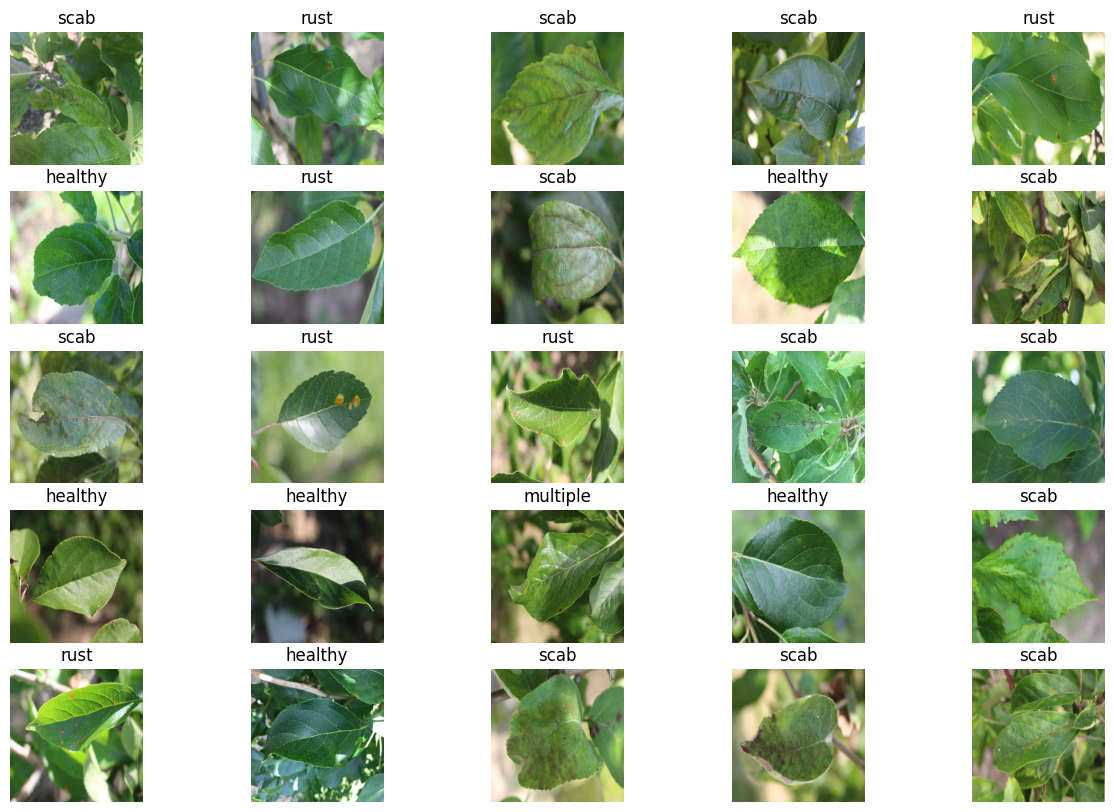

In [99]:
# Visualizing a batch of images 
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list
 
 
def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
 
plot_images(x,y)

In [105]:
# load the InceptionResNetV2 architecture with imagenet weights as base
from keras.models import load_model
weights = 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'

# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights=weights,
                     input_shape=(331,331,3)
                     )

base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
 
model = tf.keras.Sequential([ 
        base_model,   
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

In [106]:
# Defining Optimizer, Loss function and Metrics
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [107]:
early = tf.keras.callbacks.EarlyStopping(patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)
# early stopping call back

In [108]:
# Training Model
batch_size=16
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
 
# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[early])

Epoch 1/25
45/45 [==============================] - 207s 5s/step - loss: 1.0150 - accuracy: 0.5628 - val_loss: 0.7428 - val_accuracy: 0.7216
Epoch 2/25
45/45 [==============================] - 201s 4s/step - loss: 0.6489 - accuracy: 0.7607 - val_loss: 0.5737 - val_accuracy: 0.8097
Epoch 3/25
45/45 [==============================] - 197s 4s/step - loss: 0.5041 - accuracy: 0.8175 - val_loss: 0.5933 - val_accuracy: 0.8011
Epoch 4/25
45/45 [==============================] - 203s 5s/step - loss: 0.4381 - accuracy: 0.8512 - val_loss: 0.5883 - val_accuracy: 0.8040
Epoch 5/25
45/45 [==============================] - 196s 4s/step - loss: 0.3978 - accuracy: 0.8611 - val_loss: 0.6643 - val_accuracy: 0.8239
Epoch 6/25
45/45 [==============================] - 196s 4s/step - loss: 0.3249 - accuracy: 0.8898 - val_loss: 0.5901 - val_accuracy: 0.8239
Epoch 7/25
45/45 [==============================] - 196s 4s/step - loss: 0.2676 - accuracy: 0.9095 - val_loss: 0.8001 - val_accuracy: 0.7869
Epoch 8/25
45

In [109]:
# Saving Model
model.save("plant_disease_classifier.h5")

Text(0.5, 1.0, 'Training and Validation Accuracy. Train Accuracy: 0.967719316482544 Validation Accuracy: 0.8153409361839294')

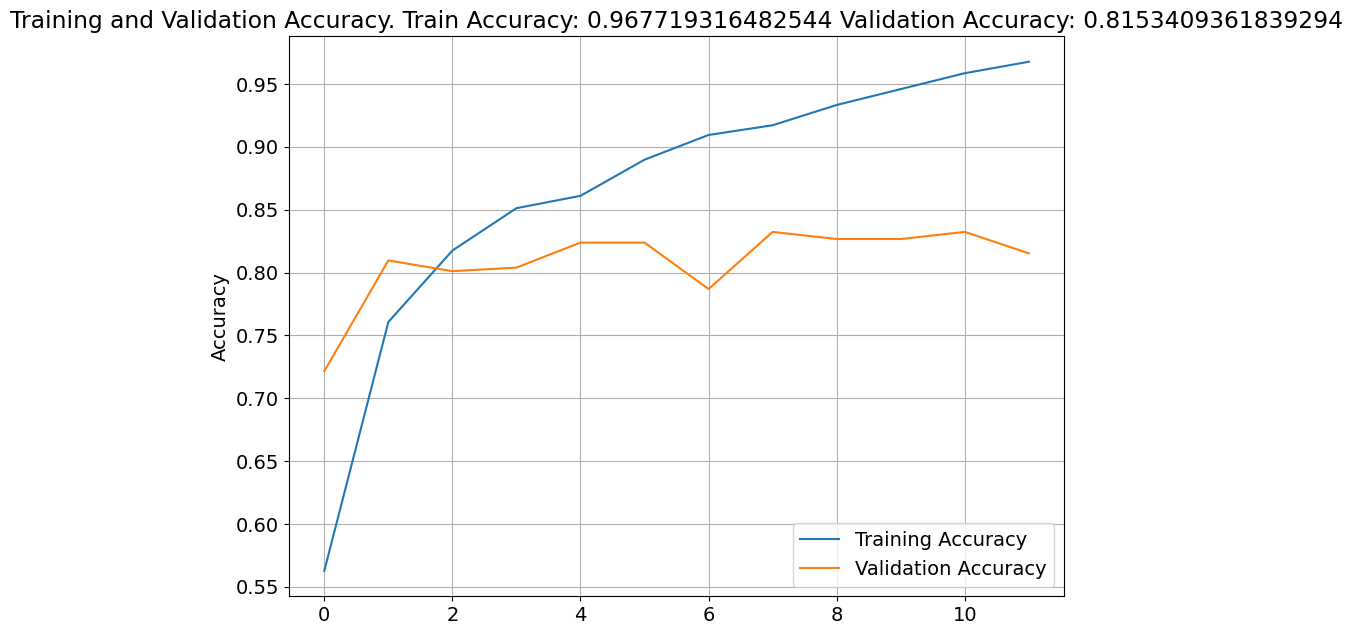

In [114]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
 
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f"Training and Validation Accuracy. Train Accuracy: {str(acc[-1])} Validation Accuracy: {str(val_acc[-1])}")

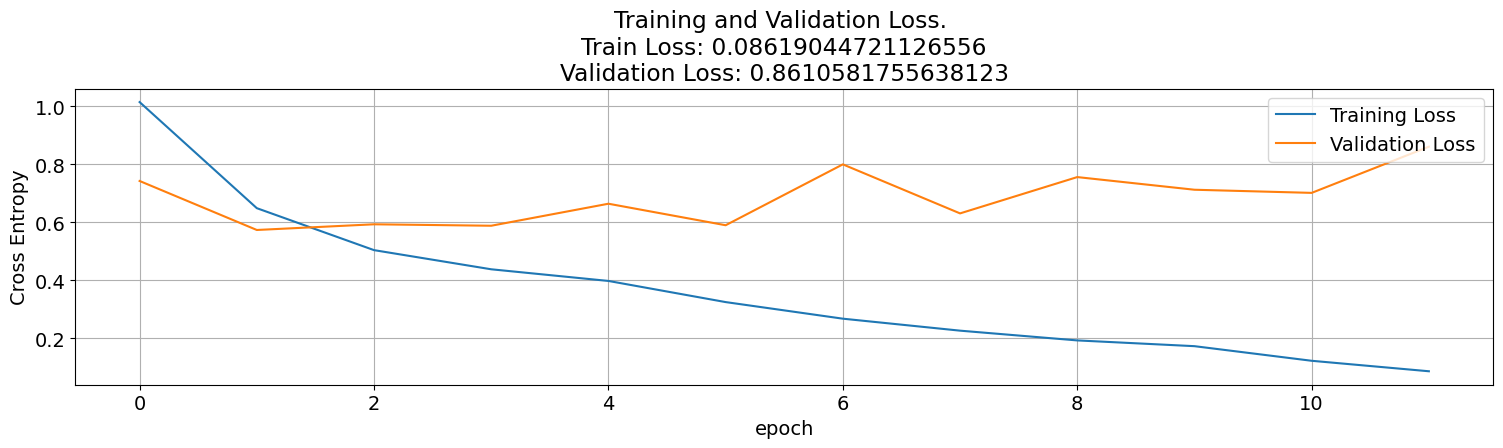

In [116]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [117]:
# Calculating Accuracy/Loss
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 
 
print("Loss: ",accuracy_score[0])

12/12 [==============================] - 43s 3s/step - loss: 0.5956 - accuracy: 0.7940
[0.5955742001533508, 0.7939560413360596]
Accuracy: 79.3956%
Loss:  0.5955742001533508


In [132]:
# Making Predictions
def make_prediction(img_path):
  """
  Predicts image.
  """
  img = tf.keras.preprocessing.image.load_img(img_path)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
  img = tf.reshape(img, (-1, 331, 331, 3))
  prediction = model.predict(img/255)
  predicted_label = class_names[np.argmax(prediction)]
  return predicted_label
 


In [142]:
img_path = "/Users/macmini/Desktop/My Work/PYTHON/AI/Machine Learning/Neural Networks/Plant Pathology(NOT FINISHED)/Data/testing_data/rust/Pelargonium rust.jpeg"
print(make_prediction(img_path)) # Displaying first five predicted output

1/1 [==============================] - 0s 216ms/step
scab


In [ ]:
# 0 : Healthy
# 3 : Rust
